BANK MARKETING: Predicting Whether The Customer Will Subscribe To Term Deposit (FIXED DEPOSIT) or not.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

url_train = 'https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Bank%20Marketing/termdeposit_train.csv'
url_test = 'https://raw.githubusercontent.com/FlipRoboTechnologies/ML-Datasets/main/Bank%20Marketing/termdeposit_test.csv'

train_df = pd.read_csv(url_train)
test_df = pd.read_csv(url_test)

train_df.head()


,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,26110,56,admin.,married,unknown,no,1933,no,no,telephone,19,nov,44,2,-1,0,unknown,no
1,40576,31,unknown,married,secondary,no,3,no,no,cellular,20,jul,91,2,-1,0,unknown,no
2,15320,27,services,married,secondary,no,891,yes,no,cellular,18,jul,240,1,-1,0,unknown,no
3,43962,57,management,divorced,tertiary,no,3287,no,no,cellular,22,jun,867,1,84,3,success,yes
4,29842,31,technician,married,secondary,no,119,yes,no,cellular,4,feb,380,1,-1,0,unknown,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31647 entries, 0 to 31646
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          31647 non-null  int64 
 1   age         31647 non-null  int64 
 2   job         31647 non-null  object
 3   marital     31647 non-null  object
 4   education   31647 non-null  object
 5   default     31647 non-null  object
 6   balance     31647 non-null  int64 
 7   housing     31647 non-null  object
 8   loan        31647 non-null  object
 9   contact     31647 non-null  object
 10  day         31647 non-null  int64 
 11  month       31647 non-null  object
 12  duration    31647 non-null  int64 
 13  campaign    31647 non-null  int64 
 14  pdays       31647 non-null  int64 
 15  previous    31647 non-null  int64 
 16  poutcome    31647 non-null  object
 17  subscribed  31647 non-null  object
dtypes: int64(8), object(10)
memory usage: 4.3+ MB


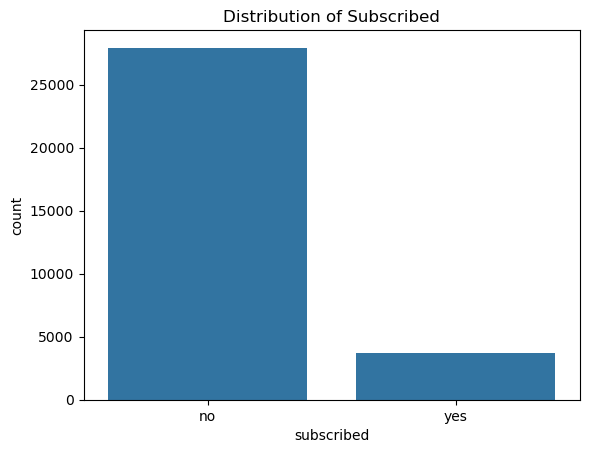

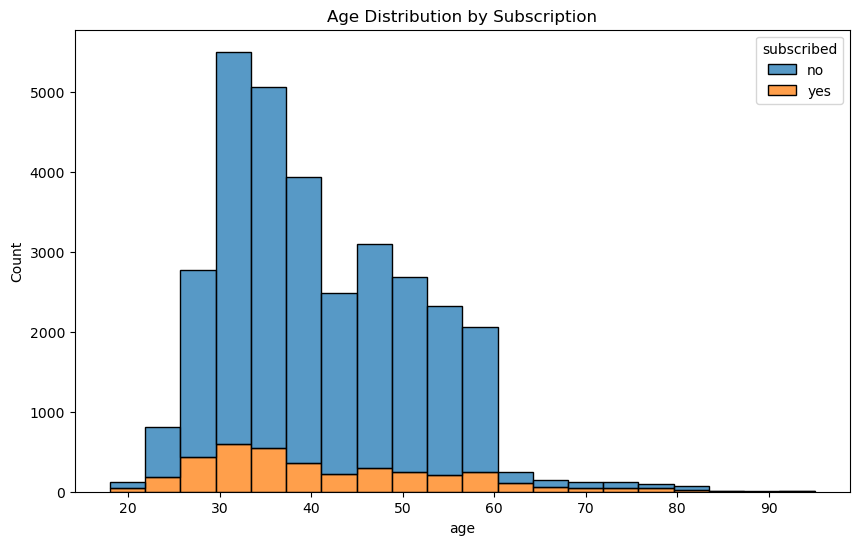

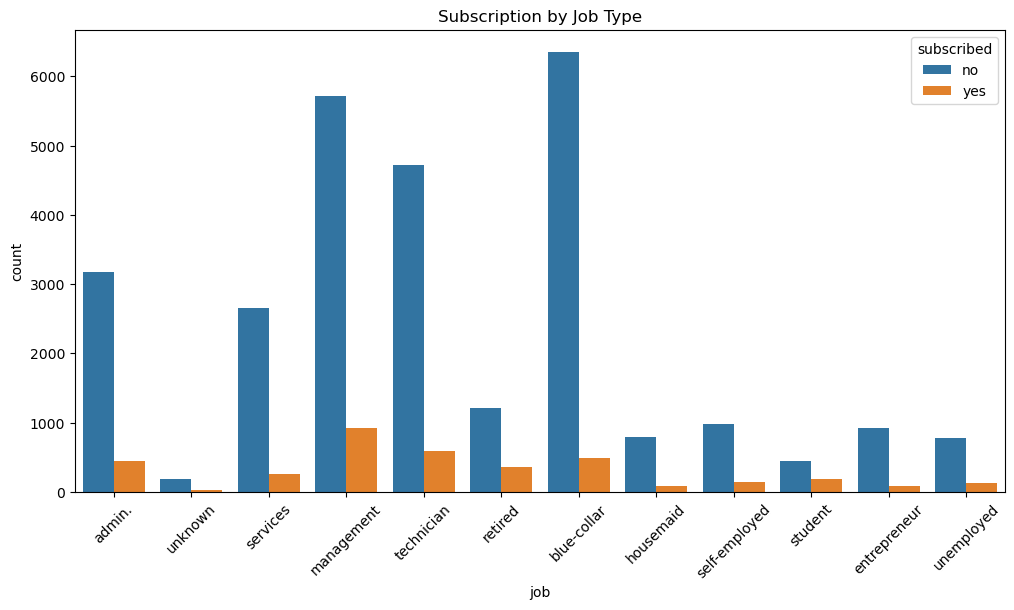

In [2]:
train_df.info()
train_df.describe()
train_df.isnull().sum()

sns.countplot(x='subscribed', data=train_df)
plt.title('Distribution of Subscribed')
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(x='age', data=train_df, hue='subscribed', multiple='stack', bins=20)
plt.title('Age Distribution by Subscription')
plt.show()
plt.figure(figsize=(12, 6))
sns.countplot(x='job', data=train_df, hue='subscribed')
plt.xticks(rotation=45)
plt.title('Subscription by Job Type')
plt.show()


In [3]:
columns_to_fill = ['age', 'job', 'marital', 'education'] 

for col in columns_to_fill:
    train_df[col] = train_df[col].ffill()
X = train_df.drop(['ID', 'subscribed'], axis=1)
y = train_df['subscribed'].map({'no': 0, 'yes': 1})

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)



In [4]:
rf_model = RandomForestClassifier(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)


Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5599
           1       0.63      0.39      0.48       731

    accuracy                           0.90      6330
   macro avg       0.78      0.68      0.72      6330
weighted avg       0.89      0.90      0.89      6330



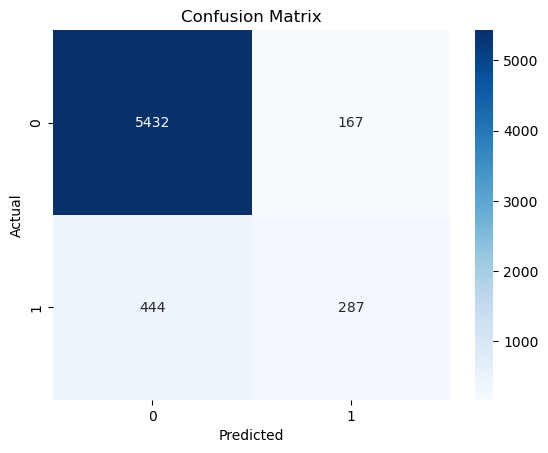

In [5]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_val, y_pred))

conf_mat = confusion_matrix(y_val, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [6]:
X_test = test_df.drop('ID', axis=1)
test_preds = pipeline.predict(X_test)

test_df['predicted_subscribed'] = test_preds
test_df.to_csv('predicted_results.csv', index=False)
